In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelBinarizer

#Left to deal with 'name', 'brand_name', 'seller_id', 'item_description'

In [77]:
import pickle

In [3]:
df_train = pd.read_csv('mercari_train.csv')

In [4]:
df_test = pd.read_csv('mercari_test.csv')

In [5]:
print('Train_Shape:',df_train.shape)
print('Test_Shape:',df_test.shape)

Train_Shape: (68400, 9)
Test_Shape: (31789, 8)


In [6]:
print('Train_columns:',df_train.columns)
print('Test_columns:',df_test.columns)

Train_columns: Index(['id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'seller_id', 'item_description'],
      dtype='object')
Test_columns: Index(['id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'shipping', 'seller_id', 'item_description'],
      dtype='object')


In [7]:
print('Train_Dtypes:\n',df_train.dtypes, '\n')
print('Test_Dtypes:\n',df_test.dtypes)

Train_Dtypes:
 id                    int64
name                 object
item_condition_id     int64
category_name        object
brand_name           object
price                 int64
shipping              int64
seller_id             int64
item_description     object
dtype: object 

Test_Dtypes:
 id                    int64
name                 object
item_condition_id     int64
category_name        object
brand_name           object
shipping              int64
seller_id             int64
item_description     object
dtype: object


In [8]:
print('Train_Nulls:\n',df_train.isna().mean(), '\n')
print('Test_Nulls:\n',df_test.isna().mean())

Train_Nulls:
 id                   0.000000
name                 0.000000
item_condition_id    0.000000
category_name        0.000000
brand_name           0.313816
price                0.000000
shipping             0.000000
seller_id            0.000000
item_description     0.099561
dtype: float64 

Test_Nulls:
 id                   0.000000
name                 0.000000
item_condition_id    0.000000
category_name        0.000000
brand_name           0.311271
shipping             0.000000
seller_id            0.000000
item_description     0.096574
dtype: float64


In [9]:
y = df_train['price']


In [10]:
df_train = df_train.drop(['price'], axis =1)
df = pd.concat([df_train, df_test], axis = 0)

In [11]:
df.reset_index(drop = True, inplace = True)

In [12]:
df.brand_name = df.brand_name.replace(np.nan, 'unknown')
df.item_description = df.item_description.fillna("None")

In [13]:
print('Final_Nulls:\n',df.isna().mean())

Final_Nulls:
 id                   0.0
name                 0.0
item_condition_id    0.0
category_name        0.0
brand_name           0.0
shipping             0.0
seller_id            0.0
item_description     0.0
dtype: float64


In [14]:
#Storing train and test in different dfs
df_train = df[:len(df_train)]
df_test = df[:len(df_test)]

In [15]:
#name is not unique
len(set(df.name))

85110

In [16]:
print('Set_Item_condition_id:',len(set(df.item_condition_id)))

Set_Item_condition_id: 5


<AxesSubplot:xlabel='item_condition_id', ylabel='count'>

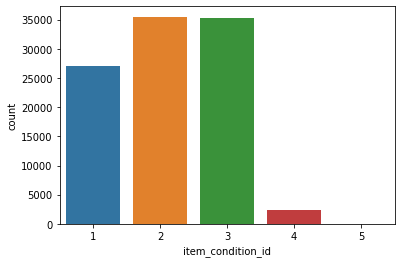

In [17]:
sns.countplot(x = 'item_condition_id', data = df)

In [18]:
print('Category_name_set:',len(set(df.category_name)))

Category_name_set: 23


In [19]:
df.category_name.value_counts()

Women/Athletic apparel/Pants, tights, leggings    13699
Women/Tops & blouses/T-shirts                     11843
Women/Tops & blouses/Blouse                        5279
Women/Tops & blouses/Tank, cami                    5062
Women/Shoes/Boots                                  4765
Women/Dresses/Above knee, mini                     4620
Women/Athletic apparel/Shorts                      4561
Women/Underwear/Bras                               4241
Women/Dresses/Knee-length                          4167
Women/Women's handbags/Shoulder Bags               3901
Women/Shoes/Sandals                                3787
Women/Jewelry/Necklaces                            3692
Women/Women's accessories/Wallets                  3343
Women/Swimwear/Two-piece                           3196
Women/Shoes/Athletic                               3190
Women/Athletic apparel/Shirts & tops               3101
Women/Jewelry/Bracelets                            3027
Women/Jeans/Slim, skinny                        

In [20]:
len(set(df.seller_id))

54688

In [21]:
len(set(df.brand_name))

1242

In [22]:
df.brand_name.value_counts()

unknown               31360
PINK                   6780
LuLaRoe                6511
Nike                   5185
Victoria's Secret      4900
                      ...  
Junk Food Clothing        1
Onitsuka Tiger            1
Krazy Kat                 1
Last Kiss                 1
LaCrosse Footwear         1
Name: brand_name, Length: 1242, dtype: int64

In [23]:
len(set(df.shipping))

2

In [24]:
#df_train[['brand_name', 'category_name', 'price']].groupby(['category_name', 'brand_name']).agg(['mean', 'median', 'std'])

In [25]:
df.item_description = df.item_description + '' + df.name + df.category_name

<AxesSubplot:xlabel='item_condition_id', ylabel='price'>

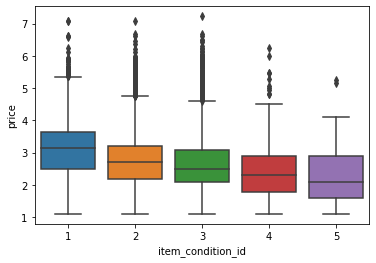

In [26]:
sns.boxplot(x=df_train['item_condition_id'], y=np.log(y))

<AxesSubplot:xlabel='category_name', ylabel='price'>

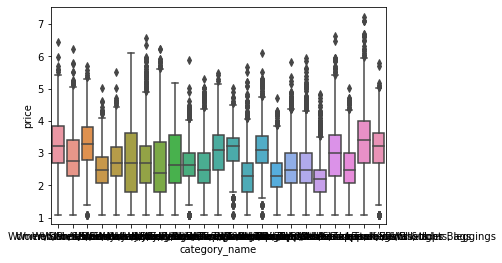

In [27]:
sns.boxplot(x=df_train['category_name'], y=np.log(y))

<AxesSubplot:xlabel='item_condition_id', ylabel='price'>

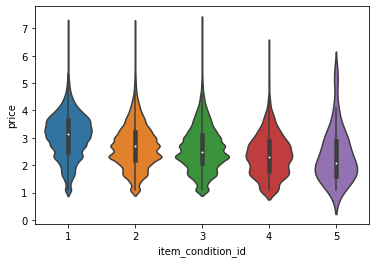

In [28]:
sns.violinplot(x=df_train['item_condition_id'], y=np.log(y))


In [29]:
#Category name to 3 different info
sc_1 = []
sc_2 = []
sc_3 = []
for feature in (df['category_name'].values):
    fs = feature.split('/')
    a,b,c = fs[0], fs[1], ' '.join(fs[2:])
    sc_1.append(a)
    sc_2.append(b)
    sc_3.append(c)
df['gender'] = sc_1
df['item'] = sc_2
df['type_item'] = sc_3

In [30]:
set(df.gender)

{'Women'}

In [31]:
df_train_with_price = pd.concat([df_train, y], 1)
df_train_with_price['log_price'] = np.log1p(df_train_with_price.price)

/var/folders/36/2w68f_916m5_4nk8vnz8j2yw0000gn/T/ipykernel_24504/3491173165.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df_train_with_price = pd.concat([df_train, y], 1)


Text(28.82265625000001, 0.5, 'PDF of log of price')

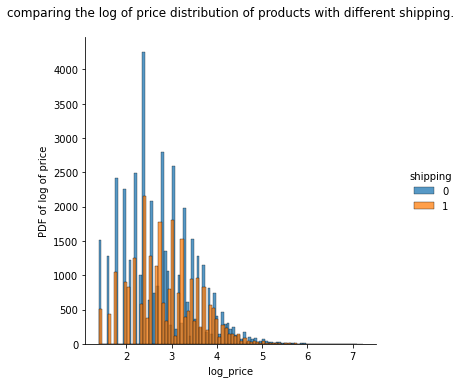

In [32]:
sns.FacetGrid(df_train_with_price, hue="shipping", height=5).map(sns.histplot, 'log_price').add_legend();
plt.title('comparing the log of price distribution of products with different shipping.\n')
plt.ylabel('PDF of log of price')

In [33]:

ps = PorterStemmer()

In [34]:
def text_pre_processing(article):
    corpus = []
    review = re.sub('[^a-zA-Z0-9]', ' ', article) #Remove everything(Punctuations, Numbers, etc... except the alphabetical words)
    review = review.lower()                     #lowercasing the words
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')] #removing stopwords and lemmatizing
    review = ' '.join(review)
    corpus.append(review)

    try: return corpus[0]
    except: return 0 #Returning final preprocessed article string

In [35]:
df['item_description'] = df['item_description'].astype(str)
df['name'] = df['name'].astype(str)

In [36]:
df.name.dtype

dtype('O')

In [37]:
#df['item_description'] = df['item_description'].apply(lambda row: text_pre_processing(row))

In [38]:
#df['name'] = df['name'].apply(lambda row: text_pre_processing(row))

In [39]:
def calc_char_len(x): # Calculating the character length of each text data
    try: return len(x)
    except: return 0

def calc_word_len(x): # Calculating the word length of each text data
    try: return len(x.split(' '))
    except: return 0

In [40]:
df['id_char_length'] = df['item_description'].apply(lambda x:calc_char_len(x))

In [41]:
df['id_word_length'] = df['item_description'].apply(lambda x:calc_word_len(x))

In [42]:
df['name_length'] = df['name'].apply(lambda x:len(x))

In [43]:
df['log_id_char_length'] = df['id_char_length'].apply(lambda x:np.log1p(x))

In [44]:
# creating new feature -> log(1 + character length of item_description)
df['log_id_word_length'] = df['id_word_length'].apply(lambda x:np.log1p(x)) 

In [45]:
df.columns

Index(['id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'shipping', 'seller_id', 'item_description', 'gender', 'item',
       'type_item', 'id_char_length', 'id_word_length', 'name_length',
       'log_id_char_length', 'log_id_word_length'],
      dtype='object')

In [46]:
print("Encodings")
count = CountVectorizer(min_df = 15)
X_name = count.fit_transform(df["name"])

Encodings


In [47]:
print("Running Description encoders")

count_descp = TfidfVectorizer(max_features = 5000, ngram_range = (1,3),stop_words = "english")

X_descp = count_descp.fit_transform(df["item_description"])

Running Description encoders


In [48]:
print("Running Brand encoders")
vect_brand = LabelBinarizer(sparse_output=True)
X_brand = vect_brand.fit_transform(df["brand_name"])

Running Brand encoders


In [49]:
X_brand.shape

(100189, 1242)

In [50]:
print("Running Dummy Encoders")
X_dummies = scipy.sparse.csr_matrix(pd.get_dummies(df[['item_condition_id','gender','shipping','item', 'type_item']], sparse = True).values)

Running Dummy Encoders


In [51]:
X_left = scipy.sparse.csr_matrix(df[['id_char_length', 'id_word_length',
       'name_length', 'log_id_char_length', 'log_id_word_length']])

In [52]:
X = scipy.sparse.hstack((X_dummies, 
                         X_descp,
                         X_brand,
                         X_left,
                         X_name)).tocsr()

print([X_dummies.shape, X_name.shape, X_descp.shape, X_brand.shape, X_left.shape])

[(100189, 37), (100189, 1803), (100189, 5000), (100189, 1242), (100189, 5)]


In [54]:
'''X = df[['item_condition_id', 'shipping', 'seller_id', 'item', 'type_item', 'id_char_length', 'id_word_length',
       'name_length', 'log_id_char_length', 'log_id_word_length']]
y = df['price']'''

"X = df[['item_condition_id', 'shipping', 'seller_id', 'item', 'type_item', 'id_char_length', 'id_word_length',\n       'name_length', 'log_id_char_length', 'log_id_word_length']]\ny = df['price']"

In [55]:
'''X = pd.get_dummies(X, columns = ['item_condition_id','item', 'type_item'])
X'''

"X = pd.get_dummies(X, columns = ['item_condition_id','item', 'type_item'])\nX"

In [56]:
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (100189, 8087)
Shape of y: (68400,)


In [57]:


model1 = Ridge(alpha=1)

In [58]:
def loss(y_train, y_pred):
    loss = np.sqrt(mean_squared_log_error(y_train, abs(y_pred)))
    return loss

In [59]:

#rmsle = make_scorer(loss, greater_is_better = True)

In [60]:
#cross_val_score(model1, X, y, cv = 10, scoring=rmsle).mean()


In [61]:

X_train, X_test, y_train, y_test = train_test_split(X[:len(df_train)], y, test_size=0.25, random_state=42)


In [62]:

model1.fit(X_train, np.log1p(y_train))
y_pred1 = model1.predict(X_test)
loss(y_test, np.expm1(y_pred1))


0.4980915734698779

In [64]:
model1.fit(X[:len(df_train)], y)

Ridge(alpha=1)

In [65]:
preds = model1.predict(X[len(df_train):])

In [79]:
pickle.dump(model1, open('model.pkl', 'wb'))

In [68]:
'''preds = pd.DataFrame(preds, columns = ['price'])'''

In [69]:
'''df_test = pd.concat([df_test, preds], 1)'''

/var/folders/36/2w68f_916m5_4nk8vnz8j2yw0000gn/T/ipykernel_24504/4216499688.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df_test = pd.concat([df_test, preds], 1)


In [70]:
'''submission = df_test[['id', 'price']]'''

In [75]:
'''submission.to_csv('submission.csv', index = False)'''

In [81]:
'''
model2 = CatBoostRegressor(random_state=42, thread_count=4, verbose=100,
                          iterations=500, loss_function='RMSE', learning_rate=0.4, early_stopping_rounds = 20)'''

In [82]:
'''model2.fit(X_train, np.log1p(y_train))
y_pred2 = model2.predict(X_test)
'''

0:	learn: 0.6908797	total: 513ms	remaining: 4m 16s
100:	learn: 0.4835638	total: 23s	remaining: 1m 31s
200:	learn: 0.4547540	total: 47.4s	remaining: 1m 10s
300:	learn: 0.4350435	total: 1m 12s	remaining: 48.2s
400:	learn: 0.4181669	total: 1m 39s	remaining: 24.5s
499:	learn: 0.4044805	total: 2m 5s	remaining: 0us


In [83]:
'''loss(y_test, np.expm1(y_pred2))'''

0.496628907839792

In [ ]:
'''np.expm1(y_pred1)'''